# Darwin Mini gait generation (research)

In [1]:
# Import some matplolib and numpy shortcuts for Jupyter notebook
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Gait generation

Try to generate a step, by moving the joints manually.

In [3]:
import time

In [4]:
def bend(a, side):
    assert side in ['l', 'r']
    o = 1 if side == 'l' else -1
    darwin.__dict__[side + '_thigh_joint'].goal_position = o*a
    darwin.__dict__[side + '_knee_joint'].goal_position = -o*a

In [5]:
def incline(a):
    darwin.l_hip_joint.goal_position = a
    darwin.r_hip_joint.goal_position = a
    darwin.l_foot_joint.goal_position = -a
    darwin.r_foot_joint.goal_position = -a

In [36]:
def rest():
    bend(0, 'l')
    bend(0, 'r')
    darwin.l_ankle_joint.goal_position = 0
    darwin.r_ankle_joint.goal_position = 0
    incline(0)
    darwin.l_shoulder_joint.goal_position = 0
    darwin.r_shoulder_joint.goal_position = 0
    darwin.l_biceps_joint.goal_position = 0
    darwin.r_biceps_joint.goal_position = 0

In [38]:
incline(30)

In [34]:
bend(60, 'l')

In [35]:
bend(20, 'r')

In [30]:
rest()

In [100]:
def leg_fwd(side):
    assert side in ['l', 'r']
    o = 1 if side == 'l' else -1
    for i in range(3):
        darwin.l_thigh_joint.goal_position = 10*o*(i+1)
        darwin.l_knee_joint.goal_position = -10*o*(i+1)
        #darwin.l_ankle_joint.goal_position = 2*(0.5*o+0.5)*i
        darwin.r_thigh_joint.goal_position = 10*o*(i+1)
        darwin.r_knee_joint.goal_position = -10*o*(i+1)
        #darwin.r_ankle_joint.goal_position = 2*(0.5*o+0.5)*i
        time.sleep(.2)

In [106]:
for i in range(6):
    incline(10)
    time.sleep(.2)
    leg_fwd('l')
    incline(0)
    time.sleep(.2)
    incline(-10)
    time.sleep(.2)
    leg_fwd('r')
    incline(0)
    time.sleep(.2)
rest()

In [103]:
darwin.l_thigh_joint.goal_position = 20
darwin.l_knee_joint.goal_position = -10
darwin.l_ankle_joint.goal_position = 10

In [10]:
incline(25)

In [110]:
darwin.l_thigh_joint.goal_position = 20

In [112]:
darwin.r_shoulder_joint.goal_position = -30

In [113]:
darwin.l_hip_joint.goal_position = 30

In [114]:
darwin.r_hip_joint.goal_position = -10

In [115]:
incline(0)
darwin.r_shoulder_joint.goal_position = 0

In [116]:
incline(-10)

In [117]:
incline(-20)

In [118]:
darwin.r_shoulder_joint.goal_position = 0

In [122]:
darwin.r_thigh_joint.goal_position = 10

In [121]:
darwin.l_shoulder_joint.goal_position = 10

In [124]:
darwin.r_thigh_joint.goal_position = 20

In [11]:
a = 25.  # deg
t = 1.  # sec
n = 8
step = a / n
dt = t / n
for i in range(n):
    incline(i*step)
    time.sleep(dt)

In [43]:
bend(0, 'r')

In [53]:
rest()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/antoinechoppin/.pyenv/versions/3.7.4/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/antoinechoppin/.pyenv/versions/3.7.4/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/antoinechoppin/dev/3p/pypot/build/lib/pypot/utils/stoppablethread.py", line 131, in _wrapped_target
    self._target()
  File "/Users/antoinechoppin/dev/3p/pypot/build/lib/pypot/utils/stoppablethread.py", line 209, in run
    make_update_loop(self, self._update)
  File "/Users/antoinechoppin/dev/3p/pypot/build/lib/pypot/utils/stoppablethread.py", line 179, in make_update_loop
    update_func()
  File "/Users/antoinechoppin/dev/3p/pypot/build/lib/pypot/vrep/controller.py", line 52, in update
    streaming=True)
  File "/Users/antoinechoppin/dev/3p/pypot/build/lib/pypot/vrep/io.py", line 362, in call_remote_api
    raise VrepIOErrors(msg)
pypot

In [52]:
incline(25)

In [46]:
darwin.l_biceps_joint.goal_position = 30

In [47]:
darwin.r_biceps_joint.goal_position = -60

In [49]:
darwin.l_knee_joint.goal_position = 30

In [27]:
darwin.l_ankle_joint.goal_position = -30

In [28]:
darwin.r_ankle_joint.goal_position = -30

I'm stopping at this point.

It's clear that making the robot walk requires to take into account the dynamics, and not just try to move the feet with static equilibrium.

I am looking back to lectures on gait generation for biped robots.

The overall approach should be something like:

- based on a goal position, define hypothetical steps around the trajectory to the goal
- have a rough idea of the COM trajectory
- for each phase of the walking (DSP - SSP - DSP - SSP), define a trajectory for the joints so that the ZMP always stays within the acceptable area

Actually, the following is a great resource, that explains step by step what we need to do:
https://scaron.info/teaching/prototyping-a-walking-pattern-generator.html

### Forward and inverse kinematics

First, let's make sure we can compute feet position from joint configuration (forward kinematics), and required joint configuration to achieve a given feet position (inverse kinematics).

We'll try the `ikpy` library which seemed to be used by `poppy_ergo_jr`.

#### Try the `ikpy` library

In [11]:
import ikpy
from ikpy.chain import Chain
from ikpy.URDF_utils import get_chain_from_joints
import numpy as np

The Darwin Mini robot has 4 link chains (+ the head).

The `ikpy` library lets us create each chain from the URDF file, by specifying the chain elements starting from the base link.

In [3]:
DARWIN_URDF = '../../darwin_mini/darwin.urdf'


def get_chain(name_templates, side):
    assert side in ['l', 'r']
    element_names = ['body_link'] + list(map(lambda s: s.format(side), name_templates))
    return Chain.from_urdf_file(DARWIN_URDF, base_elements=element_names)


arm_element_names = ['{}_shoulder_joint', '{}_shoulder_link',
                     '{}_biceps_joint', '{}_biceps_link',
                     '{}_elbow_joint', '{}_hand_link']
leg_element_names = ['{}_hip_joint', '{}_hip_link',
                     '{}_thigh_joint', '{}_thigh_link',
                     '{}_knee_joint', '{}_lowerleg_link',
                     '{}_ankle_joint', '{}_ankle_link',
                     '{}_foot_joint', '{}_foot_link']

left_arm = get_chain(arm_element_names, 'l')
right_arm = get_chain(arm_element_names, 'r')
left_leg = get_chain(leg_element_names, 'l')
right_leg = get_chain(leg_element_names, 'r')

In [4]:
d = np.deg2rad(150.)  # default angle = 0 + 150 deg
la = np.deg2rad(150. + 90.)  # left biceps angle = 90 + 150 deg
ra = np.deg2rad(150. - 90.)  # right biceps angle = -90 + 150 deg

In [5]:
print(left_arm.forward_kinematics([None, d, d, d])[:3, 3])
print(left_arm.forward_kinematics([None, d, la, d])[:3, 3])
print(right_arm.forward_kinematics([None, d, d, d])[:3, 3])
print(right_arm.forward_kinematics([None, d, ra, d])[:3, 3])
print(left_leg.forward_kinematics([None, d, d, d, d, d])[:3, 3])
print(right_leg.forward_kinematics([None, d, d, d, d, d])[:3, 3])

[-0.014  0.057 -0.014]
[-0.014  0.101  0.03 ]
[-0.014 -0.057 -0.014]
[-0.014 -0.101  0.03 ]
[-0.037  0.024 -0.124]
[-0.037 -0.024 -0.124]


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
from ikpy import plot_utils

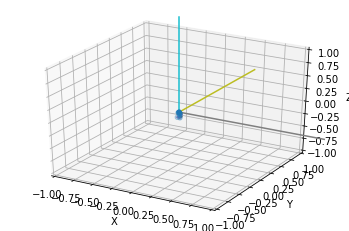

In [15]:
ax = plot_utils.init_3d_figure()
left_arm.plot([None, d, d, d], ax)
right_arm.plot([None, d, d, d], ax)
left_leg.plot([None, d, d, d, d, d], ax)
right_leg.plot([None, d, d, d, d, d], ax)

In [24]:
import logging
import sys

logger = logging.getLogger("ikpy")
logger.setLevel(logging.DEBUG)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

In [39]:
print(left_arm.forward_kinematics([None, d, d, d]))
#print(left_arm.inverse_kinematics(left_arm.forward_kinematics([None, d, d, d]), max_iter=300))
print(left_arm.inverse_kinematics(np.array([[1, 0, 0, -0.014],
                                            [0, 1, 0, 0.057],
                                            [0, 0, 1, -0.014],
                                            [0, 0, 0, 1]]),
                                  initial_position=[0, 0, 0, 0]))
print([None, d, d, d])

ikpy - INFO - Inverse kinematic optimisation OK, done in 0 iterations


[[ 1.00000000e+00  4.46722026e-24  1.49452672e-12 -1.40000000e-02]
 [ 0.00000000e+00  1.00000000e+00 -2.98905345e-12  5.70000000e-02]
 [-1.49452672e-12  2.98905345e-12  1.00000000e+00 -1.40000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[0. 0. 0. 0.]
[None, 2.6179938779914944, 2.6179938779914944, 2.6179938779914944]


In [38]:
print(left_arm.forward_kinematics([0, 0, 0, 0]))

[[-0.8660254  -0.4330127  -0.25       -0.02705256]
 [ 0.          0.5        -0.8660254   0.035     ]
 [ 0.5        -0.75       -0.4330127   0.0193923 ]
 [ 0.          0.          0.          1.        ]]


In [21]:
help(left_arm.inverse_kinematics)

Help on method inverse_kinematics in module ikpy.chain:

inverse_kinematics(target, initial_position=None, **kwargs) method of ikpy.chain.Chain instance
    Computes the inverse kinematic on the specified target
    
    Parameters
    ----------
    target: numpy.array
        The frame target of the inverse kinematic, in meters. It must be 4x4 transformation matrix
    initial_position: numpy.array
        Optional : the initial position of each joint of the chain. Defaults to 0 for each joint
    
    Returns
    -------
    The list of the positions of each joint according to the target. Note : Inactive joints are in the list.



It seems `ikpy` does not work for me.  Not sure why, but it stops the optimization even though the target position is not reached.  I have to find another way.

I noticed that `pypot` also has some kinematics module (which supports both forward and inverse kinematics), so let's give it a try.

#### Try the kinematics module of `pypot`

It seems we need to express the kinematic chain(s) of the robot using the D-H parameters.

Time to remember how to do this.

I found a great video that explains it: https://www.youtube.com/watch?v=rA9tm0gTln8

CoppeliaSim seems to have a tool to extract D-H parameters:

https://forum.coppeliarobotics.com/viewtopic.php?t=5367

Coppelia Admin suggests to use the `Models/tools/Denavit Hartenberg parameter extractor.ttm` tool, which I did.

Extracting D-H parameters using CoppeliaSim:

##### Left arm

```
Between 'l_shoulder_joint' and 'l_biceps_joint':
    d=0.0180
    theta=90.0
    a=0.0120
    alpha=90.0

Between 'l_biceps_joint' and 'l_elbow_joint':
    d=0.0000
    theta=-0.7
    a=0.0435
    alpha=0.0
```

##### Right arm

```
Between 'r_shoulder_joint' and 'r_biceps_joint':
    d=0.0180
    theta=-90.0
    a=0.0120
    alpha=-90.0

Between 'r_biceps_joint' and 'r_elbow_joint':
    d=0.0000
    theta=0.7
    a=0.0435
    alpha=0.0
```

##### Left leg

```
Between 'l_hip_joint' and 'l_thigh_joint':
    d=0.0180
    theta=0.0
    a=0.0060
    alpha=90.0

Between 'l_thigh_joint' and 'l_knee_joint':
    d=0.0000
    theta=-0.0
    a=0.0450
    alpha=0.0

Between 'l_knee_joint' and 'l_ankle_joint':
    d=0.0000
    theta=-0.0
    a=0.0420
    alpha=0.0

Between 'l_ankle_joint' and 'l_foot_joint':
    d=0.0011
    theta=179.8
    a=0.0060
    alpha=90.0
```

##### Right leg

```
Between 'r_hip_joint' and 'r_thigh_joint':
    d=0.0180
    theta=-0.0
    a=0.0060
    alpha=-90.0

Between 'r_thigh_joint' and 'r_knee_joint':
    d=0.0000
    theta=0.0
    a=0.0450
    alpha=0.0

Between 'r_knee_joint' and 'r_ankle_joint':
    d=0.0000
    theta=0.0
    a=0.0420
    alpha=0.0

Between 'r_ankle_joint' and 'r_foot_joint':
    d=0.0010
    theta=-179.8
    a=0.0060
    alpha=-90.0
```

In order to understand whether these are correct, I updated my V-REP scene, and added a frame of reference object to each joint of the scene.  At the same time, I cleaned up the joints, and made sure they follow the D-H conventions:

- x axis of the next link based at the common normal intersection
- x axis of the next link pointing away from the previous link

Saved the scene as `darwin_mini_ref.ttt`.

#### D-H parameters

I measured the D-H parameters in V-REP, and (fortunately enough) obtained the same values as reported by the V-REP plugin above.  However, I later changed the hip joint (which caused a difference in theta of the hip), **and** I figured out I had to add a frame of reference in the foot, to obtain the last line of my DH table, which V-REP had not produced.

*TODO: revise arms.*

|Link    |  d   |theta| a/r  |alpha|
|--------|------|-----|------|-----|
|l_biceps|0.0180| 90.0|0.0120| 90.0|
|l_elbow |0.0000| -0.7|0.0435|  0.0|

|Link    |  d   |theta| a/r  |alpha|
|--------|------|-----|------|-----|
|r_biceps|0.0180|-90.0|0.0120|-90.0|
|r_elbow |0.0000|  0.7|0.0435|  0.0|

|Link    |  d   |theta| a/r  |alpha|
|--------|------|-----|------|-----|
|l_hip   |0.0180|-90.0|0.0060| 90.0|
|l_thigh |0.0000|  0.0|0.0450|  0.0|
|l_knee  |0.0000|  0.0|0.0420|  0.0|
|l_ankle |0.0010|180.0|0.0060| 90.0|
|l_foot  |0.0040|-90.0|0.0090|-90.0|

|Link    |  d   |theta| a/r  |alpha|
|--------|------|-----|------|-----|
|r_hip   |0.0180| 90.0|0.0060|-90.0|
|r_thigh |0.0000|  0.0|0.0450|  0.0|
|r_knee  |0.0000|  0.0|0.0420|  0.0|
|r_ankle |0.0010|180.0|0.0060|-90.0|
|r_foot  |0.0040| 90.0|0.0090| 90.0|


As an aside, here is where the 0.7 deg angle of the elbow link come from.

In [17]:
from math import tanh
from numpy import rad2deg
rad2deg(tanh(.0005/(0.178-0.1345)))

0.6585431767973742

In [48]:
0.178-0.1345

0.04349999999999998

OK, now let's see if we can use the `pypot.kinematics` module.

In [1]:
from pypot.kinematics import Link, Chain
from numpy import deg2rad

In [11]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

Start from the hip joint, and add a last frame of ref in the foot, following the DH convention.  Then, we will need to define the transformation between this last frame of ref and the base of the foot on the floor (= "end effector").

Note: At first, I had defined an additional "fake joint" between the pelvis and the hip, but this turned out not to be correct.  Instead, I had to define a frame of reference in the foot, to which the last link in the chain would map the foot joint to.

In [2]:
#l_biceps = Link(d=0.0180, theta=deg2rad(90.0), a=0.0120, alpha=deg2rad(90.0))
#l_elbow  = Link(d=0.0000, theta=deg2rad(-0.7), a=0.0435, alpha=deg2rad(0.0))

#r_biceps = Link(d=0.0180, theta=deg2rad(-90.0), a=0.0120, alpha=deg2rad(-90.0))
#r_elbow  = Link(d=0.0000, theta=deg2rad(0.7), a=0.0435, alpha=0.0)

l_hip    = Link(d=0.0180, theta=deg2rad(-90.0), a=0.0060, alpha=deg2rad(90.0))
l_thigh  = Link(d=0.0000, theta=0.0, a=0.0450, alpha=0.0)
l_knee   = Link(d=0.0000, theta=0.0, a=0.0420, alpha=0.0)
l_ankle  = Link(d=0.0010, theta=deg2rad(180.0), a=0.0060, alpha=deg2rad(90.0))
l_foot   = Link(d=0.0040, theta=deg2rad(-90.0), a=0.0090, alpha=deg2rad(-90.0))

r_hip    = Link(d=0.0180, theta=deg2rad(90.0), a=0.0060, alpha=deg2rad(-90.0))
r_thigh  = Link(d=0.0000, theta=0.0, a=0.0450, alpha=0.0)
r_knee   = Link(d=0.0000, theta=0.0, a=0.0420, alpha=0.0)
r_ankle  = Link(d=0.0010, theta=deg2rad(-180.0), a=0.0060, alpha=deg2rad(-90.0))
r_foot   = Link(d=0.0040, theta=deg2rad(90.0), a=0.0090, alpha=deg2rad(90.0))

Determine transformation matrices of the first joint of each kinematic chain, wrt the body.

In [3]:
# > sim.getObjectHandle('l_shoulder_joint')
# 21
# > sim.getObjectHandle('body_respondable')
# 19
# > sim.getObjectMatrix(21, 19)
# {1, -4.144544619e-08, 6.961163308e-06, 0.001000333577, -6.961163308e-06, -1.192092896e-06, 1.000000119, 0.03899861872, -4.14383976e-08, -1.000000119, -1.192092896e-06, 0.0300001204} 

# l_shoulder_T = [[1, 0, 0, 0.001],
#                 [0, 0, 1, 0.039],
#                 [0, -1, 0, 0.030],
#                 [0, 0, 0, 1]]

# {1, 4.067101145e-08, -6.94807477e-06, 0.0009997934103, -6.94807477e-06, 1.192092896e-06, -1, -0.03900143132, -4.06619165e-08, 1, 1.192092896e-06, 0.0300001502} 
# r_shoulder_T = [[1, 0, 0, 0.001],
#                 [0, 0, -1, -0.039],
#                 [0, 1, 0, 0.030],
#                 [0, 0, 0, 1]]

## {1.788139343e-07, 6.794906767e-06, 1, -0.001999982633, 1.171752047e-07, 1, -6.794906767e-06, 0.02399860322, -1, 1.171765689e-07, 1.788139343e-07, -0.04199992865} 
l_hip_T = [[0, 0, 1, -0.002],
          [1, 0, 0, 0.024],
          [0, 1, 0, -0.042],
          [0, 0, 0, 1]]

## {-2.026557922e-06, 6.710644811e-06, 1.000000119, -0.001999982633, -5.143601811e-08, 1, -6.710644811e-06, -0.02400141023, -1.000000119, -5.144852366e-08, -2.026557922e-06, -0.04200158268} 
r_hip_T = [[0, 0, 1, -0.002],
          [-1, 0, 0, -0.024],
          [0, -1, 0, -0.042],
          [0, 0, 0, 1]]


Determine transformation matrices of each end effector (for now, only feet) wrt to their respective joint.

In [4]:
l_foot_T = [[0, 1, 0, 0.0],
            [-1, 0, 0, 0.0],
            [0, 0, 1, -0.031],
            [0, 0, 0, 1]]

r_foot_T = [[0, -1, 0, 0.0],
            [1, 0, 0, 0.0],
            [0, 0, 1, -0.031],
            [0, 0, 0, 1]]


(For some reason, there is a difference of 1mm in the z direction, not exactly sure why)

Now, we can define the kinematic chains for the legs.

In [5]:
l_leg = Chain([l_hip, l_thigh, l_knee, l_ankle, l_foot], l_hip_T, l_foot_T)
r_leg = Chain([r_hip, r_thigh, r_knee, r_ankle, r_foot], r_hip_T, r_foot_T)

In [6]:
d = 0.

In [7]:
l_foot_pos = l_leg.forward_kinematics([d, d, d, d, d])
l_foot_pos[0][:3,3]

matrix([[ 0.02 ],
        [ 0.032],
        [-0.16 ]])

In [8]:
r_foot_pos = r_leg.forward_kinematics([d, d, d, d, d])
r_foot_pos[0][:3,3]

matrix([[ 0.02 ],
        [-0.032],
        [-0.16 ]])

In [12]:
l_foot_pos[0]

matrix([[ 1.   ,  0.   ,  0.   ,  0.02 ],
        [ 0.   ,  1.   , -0.   ,  0.032],
        [-0.   ,  0.   ,  1.   , -0.16 ],
        [ 0.   ,  0.   ,  0.   ,  1.   ]])

OK, this looks good, since the `body_respondable` is at 160mm above the ground, so at the default joint position of 0, both feet are at -160mm wrt the body, that is, right on the ground.

Now, let's check inverse kinematics.

In [13]:
l_leg.inverse_kinematics([[1, 0, 0, 0.02],
                          [0, 1, 0, 0.032],
                          [0, 0, 1, -0.160],
                          [0, 0, 0, 1]])

matrix([[-0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [-0.]])

OK, that wasn't super hard.
Now, let's try to bend the leg.

In [14]:
l_leg.inverse_kinematics([[1, 0, 0, 0.02],
                          [0, 1, 0, 0.032],
                          [0, 0, 1, -0.110],  # z position is closer to the body (=> leg is shorter)
                          [0, 0, 0, 1]],
                         q=np.array([0., 0.5, -0.3, 0.5, 0.]),   # initial joint position makes it easier to converge
                         tolerance=0.002,  # need to make the tolerance tighter, as its default was 0.05
                         max_iter=10000)   # need more iterations to converge

matrix([[-0.005],
        [ 1.05 ],
        [-2.216],
        [ 1.165],
        [ 0.005]])

In [15]:
l_leg.forward_kinematics([[-0.005],
        [ 1.05 ],
        [-2.216],
        [ 1.165],
        [ 0.005]])[0]

matrix([[ 1.   ,  0.   ,  0.001,  0.02 ],
        [-0.   ,  1.   , -0.   ,  0.032],
        [-0.001, -0.   ,  1.   , -0.112],
        [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [18]:
list(map(rad2deg, [-0.005, 1.05, -2.216, 1.165, 0.005]))

[-0.2864788975654116,
 60.160568488736445,
 -126.96744740099044,
 66.74958313274091,
 0.2864788975654116]

At least, it's doing something.

And actually, I think I can create a very simple inverse kinematic closed form (i.e. a python function) that does not need to do optimization, by just setting joints to a given angle which can be computed based on the leg length that needs to be achieved.

#### Closed form Inverse Kinematics based

![Darwin Mini joint diagram](assets/darwin-joint-diagram.png)

Assumption: foot is flat againsta the floot (no pitch nor roll)<br>
=> `q0` and `q4` must have same amplitude<br>
=> `q3 = q2 - q1`

Define `L` as the length of the leg as seen from the front view:<br>
`L * cos(q0) = (0.118 - 0.031 - dz)`<br>
`L * sin(q0) = dy`

`q0 = atan(dy / (0.118 - 0.031 - dz))`<br>
`L = dy / sin(q0)`<br>


Find the angle of the leg in the leg plane:<br>
`alpha = atan(dx / (L - a1 + a4))`<br>

Define `d` as the distance from thigh to ankle (just 2 links, thigh and lower leg):<br>
`d = dx / sin(alpha)`<br>

Compute the angles of the thigh-knee-ankle triangle:<br>
`beta1 = acos((a2**2 + d**2 - a3**2) / (2 * a2 * d))`<br>
`beta3 = acos((a3**2 + d**2 - a2**2) / (2 * a3 * d))`<br>
(`beta2 = pi - beta1 - beta3`)<br>

Find the angles of the thigh, knee and ankle joints:<br>
`q1 = beta1 + alpha`<br>
`q3 = beta3 - alpha`<br>
`q2 = -(q1 + q3)`<br>

Finally, find the angle of the foot:<br>
`q4 = -q0`

<img src="assets/darwin-3d-joint-config.png" width="400px">

In [19]:
from math import sin, acos, atan


EPS = 1e-6
# PELVIS_HEIGHT = 0.118
# FOOT_JOINT_HEIGHT = 0.031
a1 = 0.006
a2 = 0.045
a3 = 0.042
a4 = 0.006


def darwin_leg_ik(dx, dy, dz):
    assert dz >= 0  # dx and dy are allowed to be negative
    q = [.0] * 5
    #q[0] = atan(dy / (PELVIS_HEIGHT - FOOT_JOINT_HEIGHT - dz))
    q[0] = atan(dy / (a1 + a2 + a3 - a4 - dz))
    # length of the leg as seen from the front view
    L = dy / sin(q[0]) if abs(dy) > EPS else a1 + a2 + a3 - a4 - dz
    assert L <= a1 + a2 + a3 - a4, "Leg cannot be extended beyond limit. Use larger dz and/or smaller dy."
    # angle of the leg in the leg plane
    alpha = atan(dx / (L - a1 + a4))
    # distance from thigh to ankle (just 2 links, thigh and lower leg)
    d = dx / sin(alpha) if abs(dx) > EPS else L - a1 + a4
    assert d <= a2 + a3, "Leg cannot be extended beyond limit. Use larger dz, smaller dy and/or smaller dx."
    # angles of the thigh-knee-ankle triangle
    beta1 = acos((a2**2 + d**2 - a3**2) / (2 * a2 * d))
    beta3 = acos((a3**2 + d**2 - a2**2) / (2 * a3 * d))
    # angles of the thigh, knee and ankle joints
    q[1] = beta1 + alpha
    q[3] = beta3 - alpha
    q[2] = -(q[1] + q[3])
    # angle of the foot
    q[4] = -q[0] if abs(q[0]) > EPS else 0.0
    return q

In [20]:
import numpy as np
from numpy import deg2rad

In [21]:
for p in [(.0, .0, .0),
          (.0, .0, .0001),
          (.01, .0, .015),
          (.01, .0, .025),
          (.0, .0, .025),
          (-.01, .0, .025),
          (-.06, .0, .025),
          (.0, .01, .025),
          (.01, .01, .025)]:
    q = darwin_leg_ik(*p)
    print(p, q)
    print(l_leg.forward_kinematics(q)[1][-1][:3,3].flatten())

(0.0, 0.0, 0.0) [0.0, 0.0, -1.4901161193847656e-08, 1.4901161193847656e-08, 0.0]
[ 0.02   0.032 -0.16 ]
(0.0, 0.0, 0.0001) [0.0, 0.04632374552146888, -0.09595895906560492, 0.04963521354413603, 0.0]
[ 0.02   0.032 -0.16 ]
(0.01, 0.0, 0.015) [0.0, 0.6974053630099005, -1.1641812731724044, 0.46677591016250397, 0.0]
[ 0.03   0.032 -0.145]
(0.01, 0.0, 0.025) [0.0, 0.8917183479877758, -1.5297795358050728, 0.6380611878172969, 0.0]
[ 0.03   0.032 -0.135]
(0.0, 0.0, 0.025) [0.0, 0.7441512259046479, -1.556245548789148, 0.8120943228845001, 0.0]
[ 0.02   0.032 -0.135]
(-0.01, 0.0, 0.025) [0.0, 0.5718921016713373, -1.5297795358050728, 0.9578874341337354, 0.0]
[ 0.01   0.032 -0.135]
(-0.06, 0.0, 0.025) [0.0, -0.6445341446890939, -0.2578862732524676, 0.9024204179415615, 0.0]
[-0.04   0.032 -0.135]
(0.0, 0.01, 0.025) [0.1599131231582193, 0.7318052248295566, -1.5297795358050728, 0.7979743109755162, -0.1599131231582193]
[ 0.02   0.042 -0.135]
(0.01, 0.01, 0.025) [0.1599131231582193, 0.8773303299273614, -

OK, now we have solved the forward and inverse kinematics problems, let's go back to gait generation.

### Gait generation

The following video was helpful to understand what needs to be done:<br>
https://www.youtube.com/watch?v=EUZLMSqyd9Q

#### Single Support Phase


##### Cartesian Trajectory

1. Define the COM (**pelvis**) trajectory wrt the **stable leg** foot
1. Define the **swing leg** foot trajectory wrt the **pelvis**

##### Joint Trajectory

1. Apply IK on **stable leg** chain (with foot fixed) to determine stable leg joint positions
1. Apply IK on **swing leg** chain (with pelvis fixed) to determine swing leg joint positions

#### Double Support Phase

...